In [1]:
import pickle
import os
from typing import List, Dict, Tuple

class FLConfiguration:
    def __init__(self, date, time, db, alpha, strat_variant, d, ck, opt, dur, rounds=None, seed=None):
        self.date = date
        self.time = time # time when the simulation was run
        self.db = db
        self.alpha = alpha
        self.variant = strat_variant
        self.d = d
        self.ck = ck
        self.opt = opt
        self.clients = 10
        self.rounds = rounds
        self.duration = dur # how long it took
        self.seed = seed

    def __str__(self):
        return '{}/{}/'.format(self.date, self.time) + '_'.join([self.db, self.variant, 'd{}'.format(self.d), 'CK{}'.format(self.ck)])

In [2]:
# Find all results.pkl files in 'outputs' folder

EXPERIMENTS: List[FLConfiguration] = []
for alpha in os.listdir('outputs'):
    if alpha.startswith('.'):
        continue
    for day in os.listdir(os.path.join('outputs', alpha)):
        if day.startswith('.'):
            continue
        for time in os.listdir(os.path.join('outputs', alpha, day)):
            if time.startswith('.'):
                continue
            for exp in os.listdir(os.path.join('outputs', alpha, day, time)):
                if exp.startswith('.'):
                    continue           
                curr_folder = os.path.join('outputs', alpha, day, time, exp)
                if os.path.isdir(curr_folder) and 'results.pkl' in os.listdir(curr_folder):
                    fields = exp.split('_')
                    d = int(fields[2].replace('d', ''))
                    ck = int(fields[3].replace('CK', ''))
                    a = float(alpha.replace('alpha', ''))
    
                    log_file = [f for f in os.listdir(curr_folder) if '.log' in f][0]
                    opt = log_file.split('_')[1].replace('.log', '')
    
                    with open(curr_folder + '/' + log_file) as log:
                        lines = log.readlines()
                        try:
                            dur = [l for l in lines if 'FL finished in' in l][0]
                            dur = float(dur.split('FL finished in ')[1].replace('\n', ''))
                        except IndexError:
                            print('{} did not complete successfully.'.format(exp))
                            continue
                    
                    EXPERIMENTS.append(FLConfiguration(day, time, fields[0], a, fields[1], d, ck, opt, dur))

# Parse found .pkl files

data = []
results: Dict[FLConfiguration, Tuple[List[float], List[float]]] = {}
for exp in EXPERIMENTS:
    file_path = 'outputs/alpha{}/{}/results.pkl'.format(exp.alpha, str(exp))
    with open(file_path, 'rb') as file:
        data.append(pickle.load(file))
        # Accuracy and loss evolution for a single experiments over the different rounds
        latest_acc = [tup[1] for tup in data[-1]['history'].metrics_centralized['accuracy']]
        latest_loss = [tup[1] for tup in data[-1]['history'].losses_centralized]
        exp.rounds = len(latest_acc)
        results[exp] = (latest_acc, latest_loss)

print('Found {} experiments'.format(len(EXPERIMENTS)))

Found 154 experiments


In [3]:
# Find all results.pkl files in 'outputs' folder

for day in os.listdir('../../dyn_selector/dyn_selector/outputs'):
    if day.startswith('.'):
        continue
    for exp in os.listdir(os.path.join('../../dyn_selector/dyn_selector/outputs', day)):
        if exp.startswith('.'):
            continue           
        curr_folder = os.path.join('../../dyn_selector/dyn_selector/outputs', day, exp)
        if os.path.isdir(curr_folder) and 'results.pkl' in os.listdir(curr_folder):
            fields = exp.split('_')
            a = float(fields[2].replace('a', ''))

            log_file = [f for f in os.listdir(curr_folder) if '.log' in f][0]
            opt = log_file.split('_')[1].replace('.log', '')

            with open(curr_folder + '/' + log_file) as log:
                lines = log.readlines()
                try:
                    dur = [l for l in lines if 'FL finished in' in l][0]
                    dur = float(dur.split('FL finished in ')[1].replace('\n', ''))
                except IndexError:
                    print('{} did not complete successfully.'.format(exp))
                    continue
            
            EXPERIMENTS.append(FLConfiguration(day, None, fields[1], a, 'dyn', None, None, opt, dur, rounds=None, seed=fields[4]))

# Parse found .pkl files

data = []
for exp in EXPERIMENTS:
    if exp.variant!='dyn':
        continue
    file_path = '../../dyn_selector/dyn_selector/outputs/{}/{}_{}_a{}_beta0.1_{}/results.pkl'.format(exp.date, exp.opt, exp.db, exp.alpha, exp.seed)
    with open(file_path, 'rb') as file:
        data.append(pickle.load(file))
        # Accuracy and loss evolution for a single experiments over the different rounds
        latest_acc = [tup[1] for tup in data[-1]['history'].metrics_centralized['accuracy']]
        latest_loss = [tup[1] for tup in data[-1]['history'].losses_centralized]
        exp.rounds = len(latest_acc)
        results[exp] = (latest_acc, latest_loss)

print('Found {} experiments'.format(len(EXPERIMENTS)))

Found 193 experiments


/var/folders/wf/vl_sy5yj7fjgz0r9rn5xbvf00000gn/T/ipykernel_40229/1171377174.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


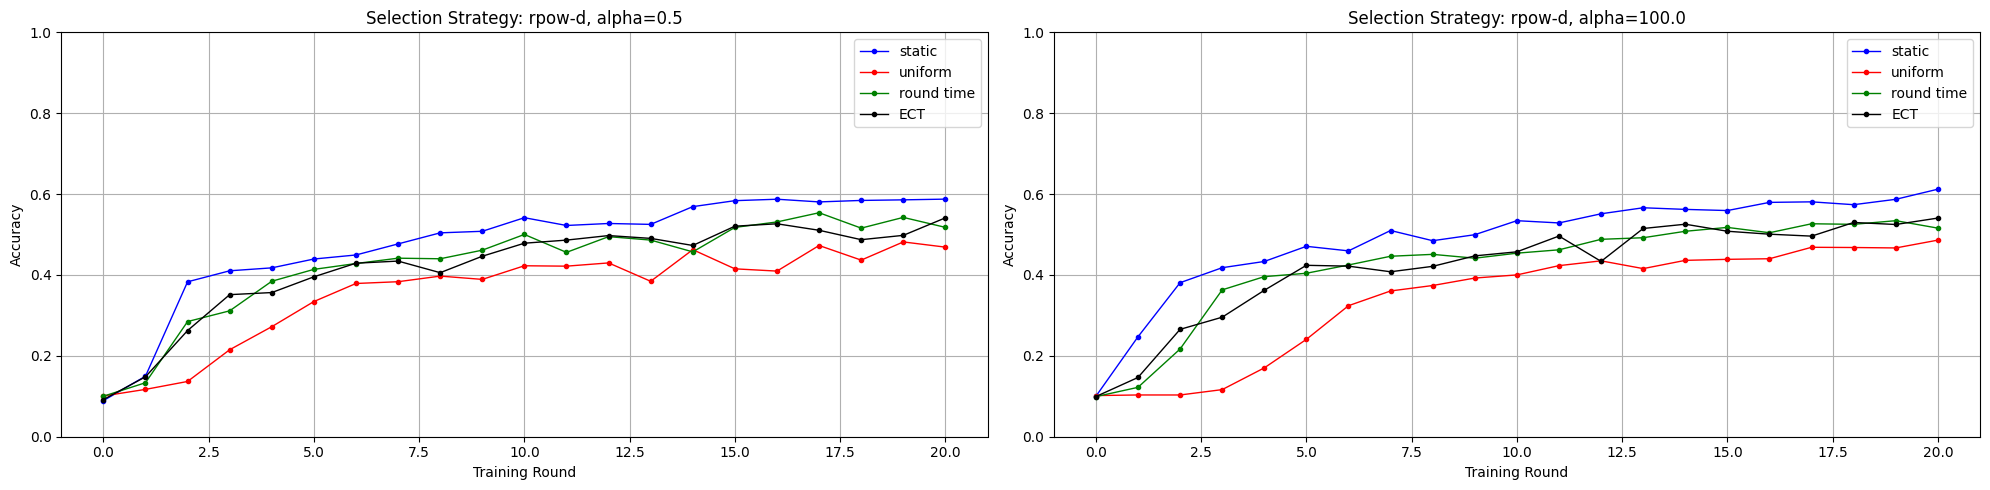

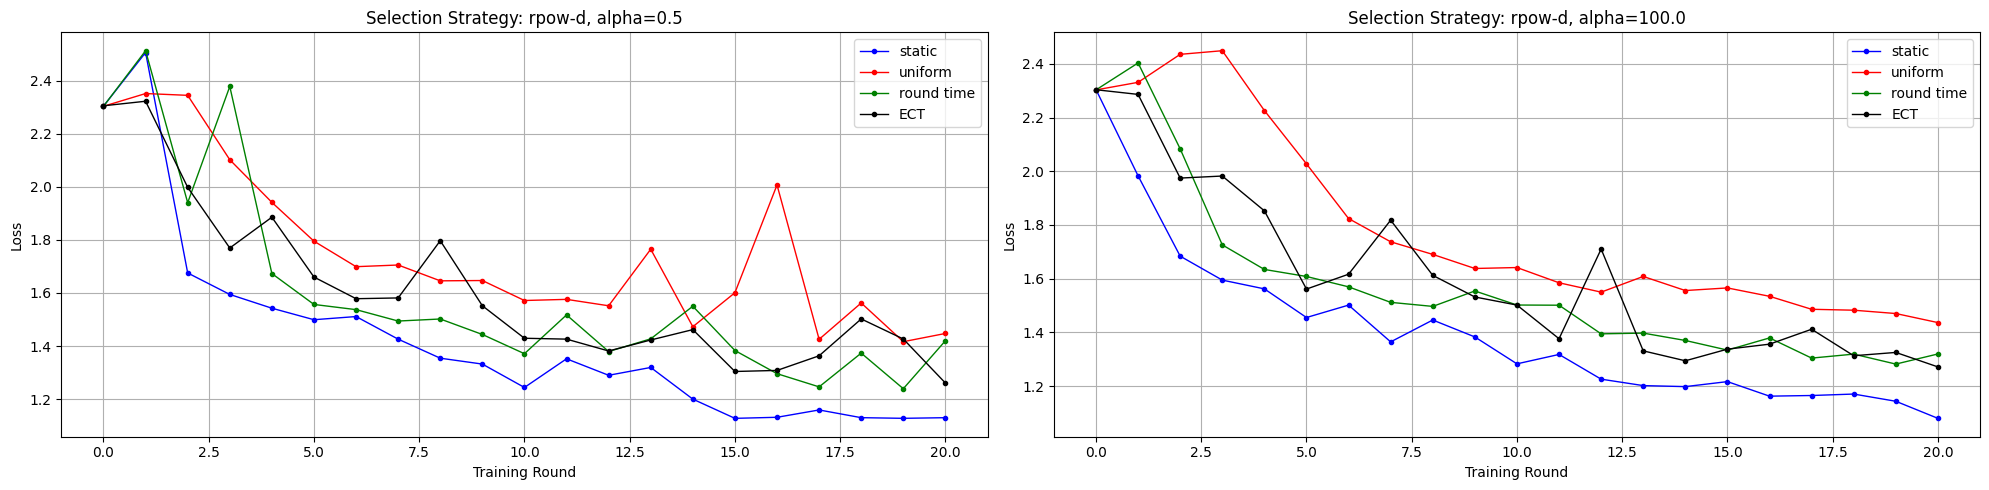

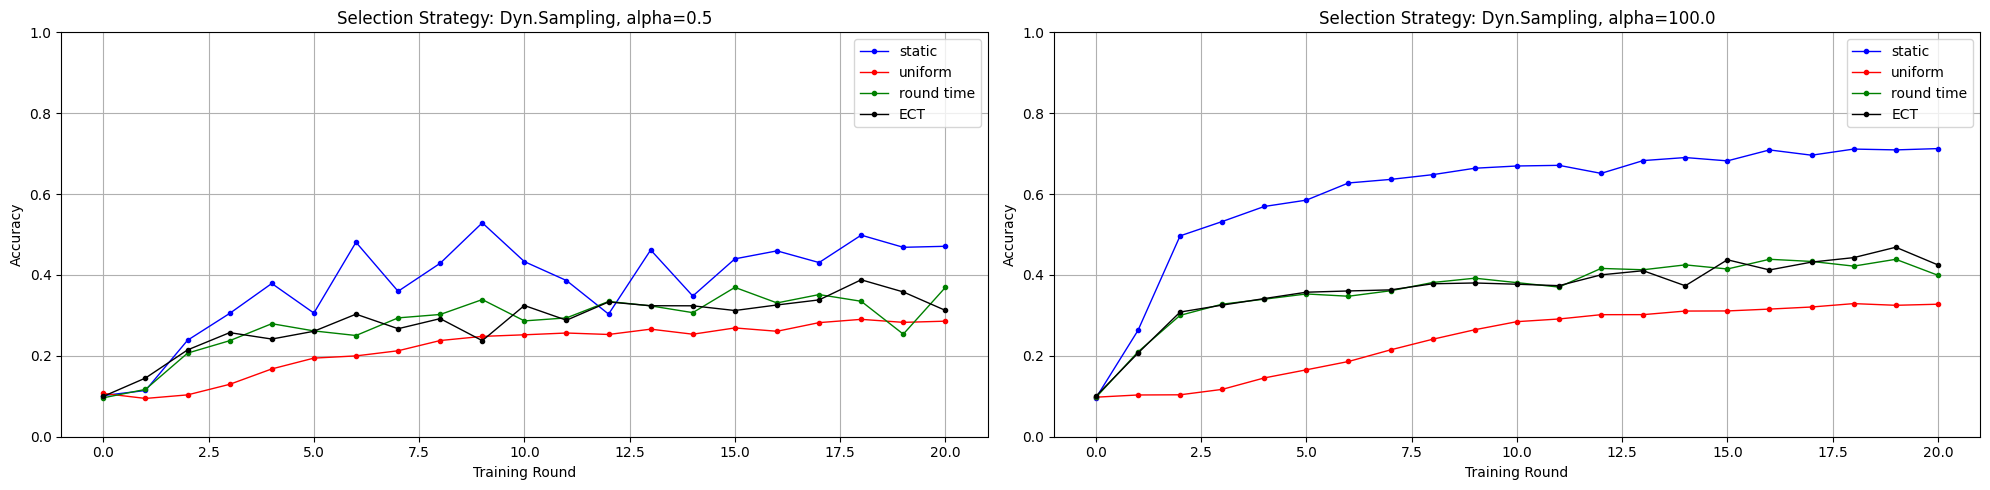

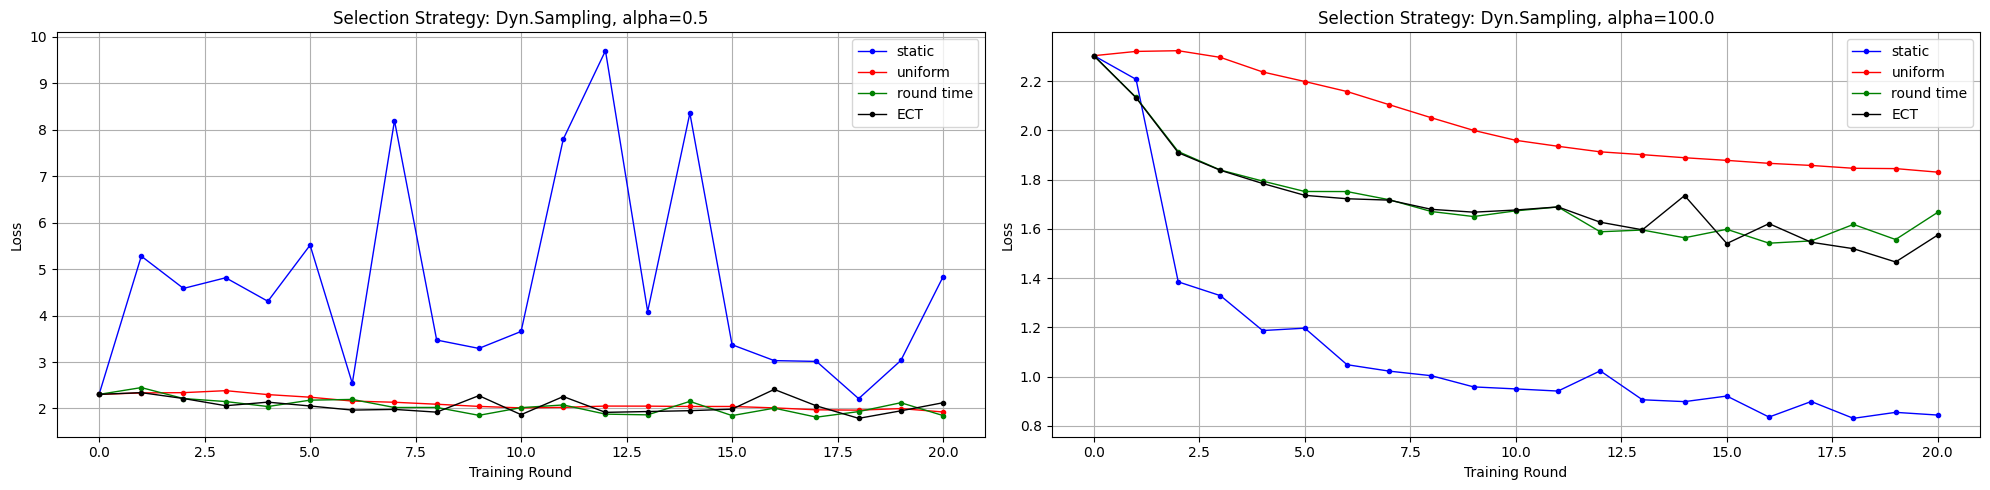

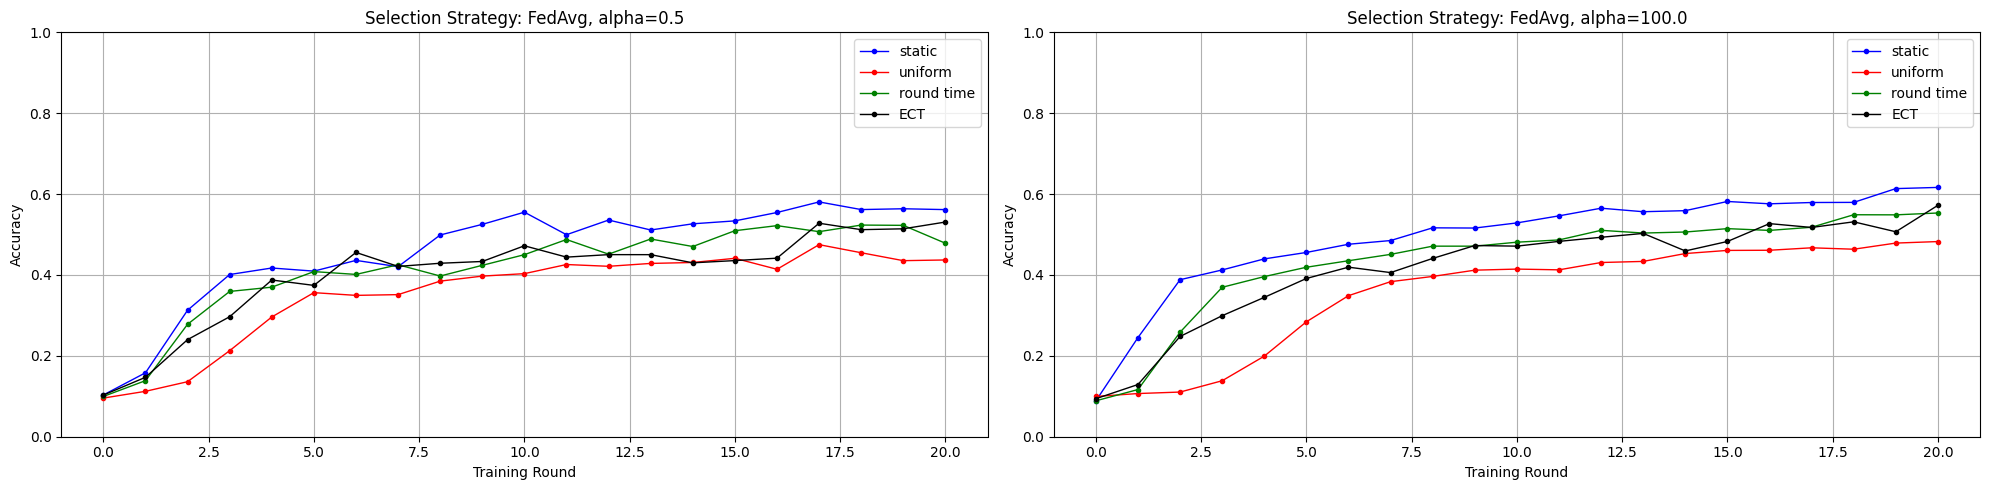

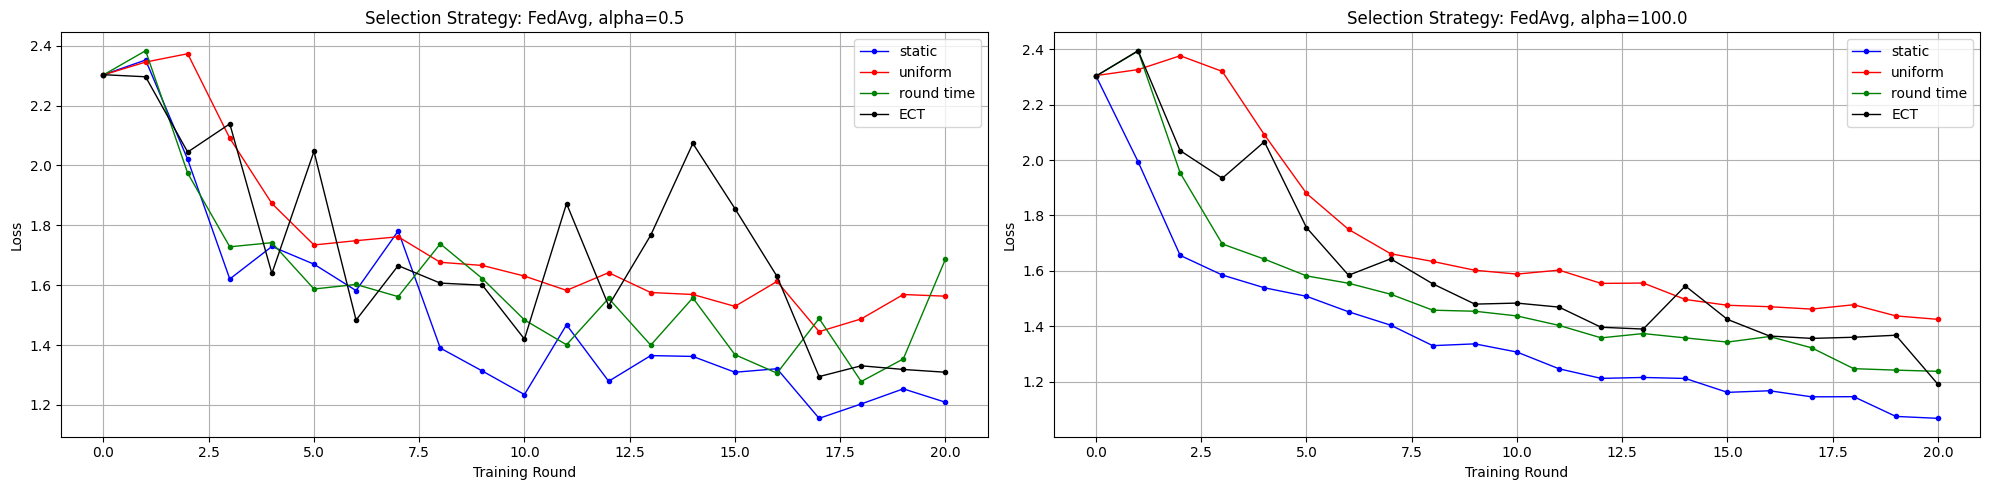

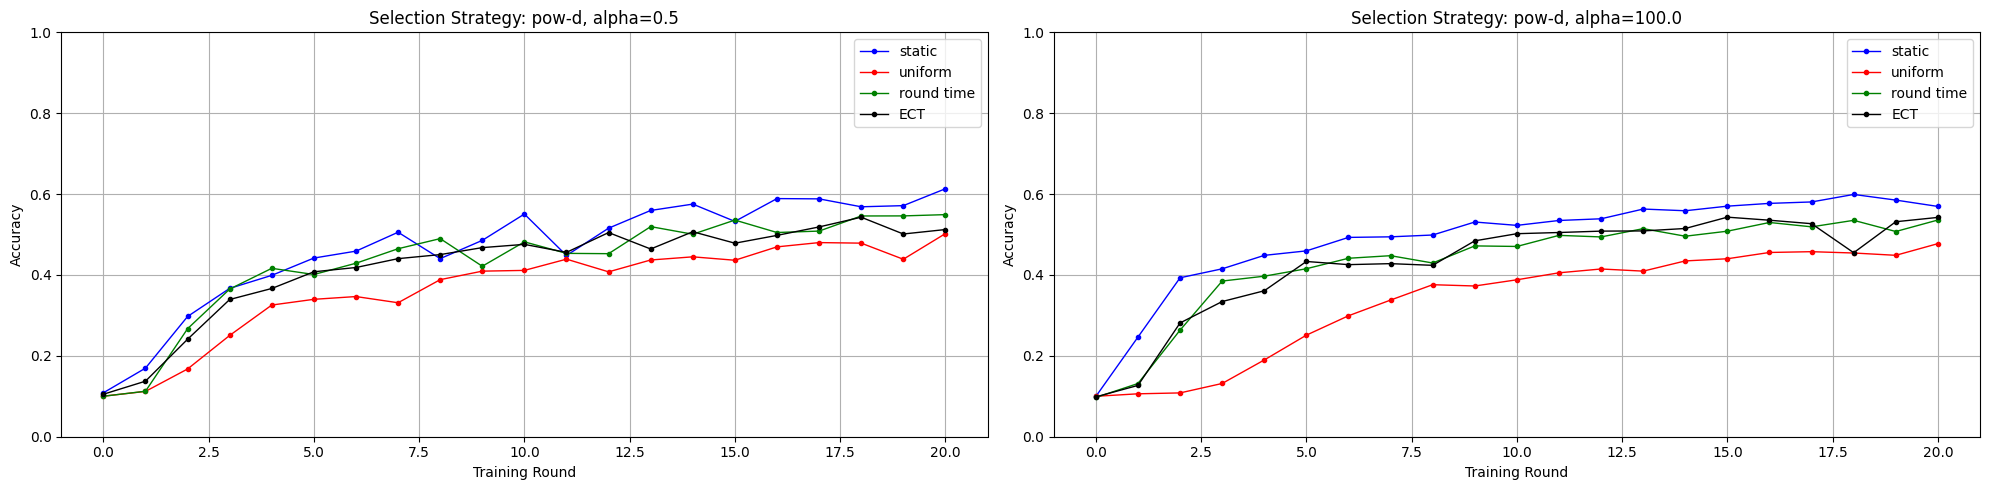

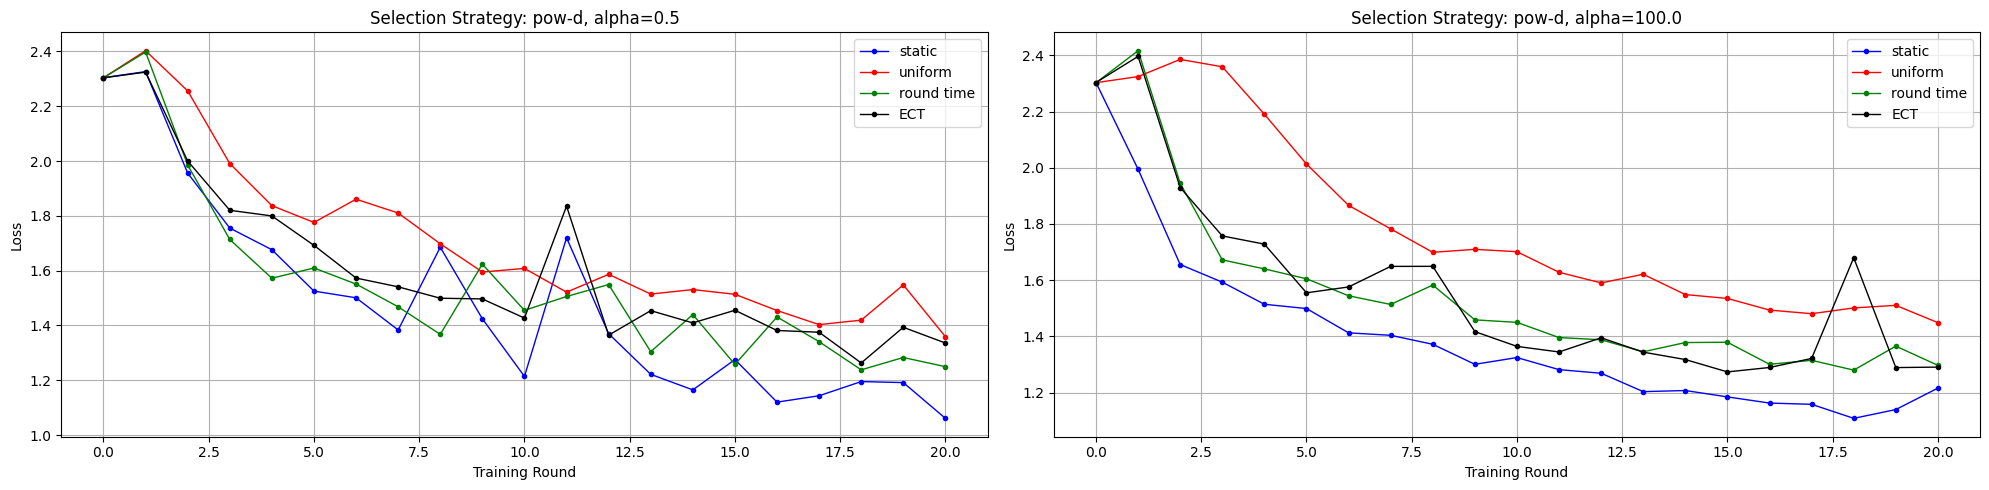

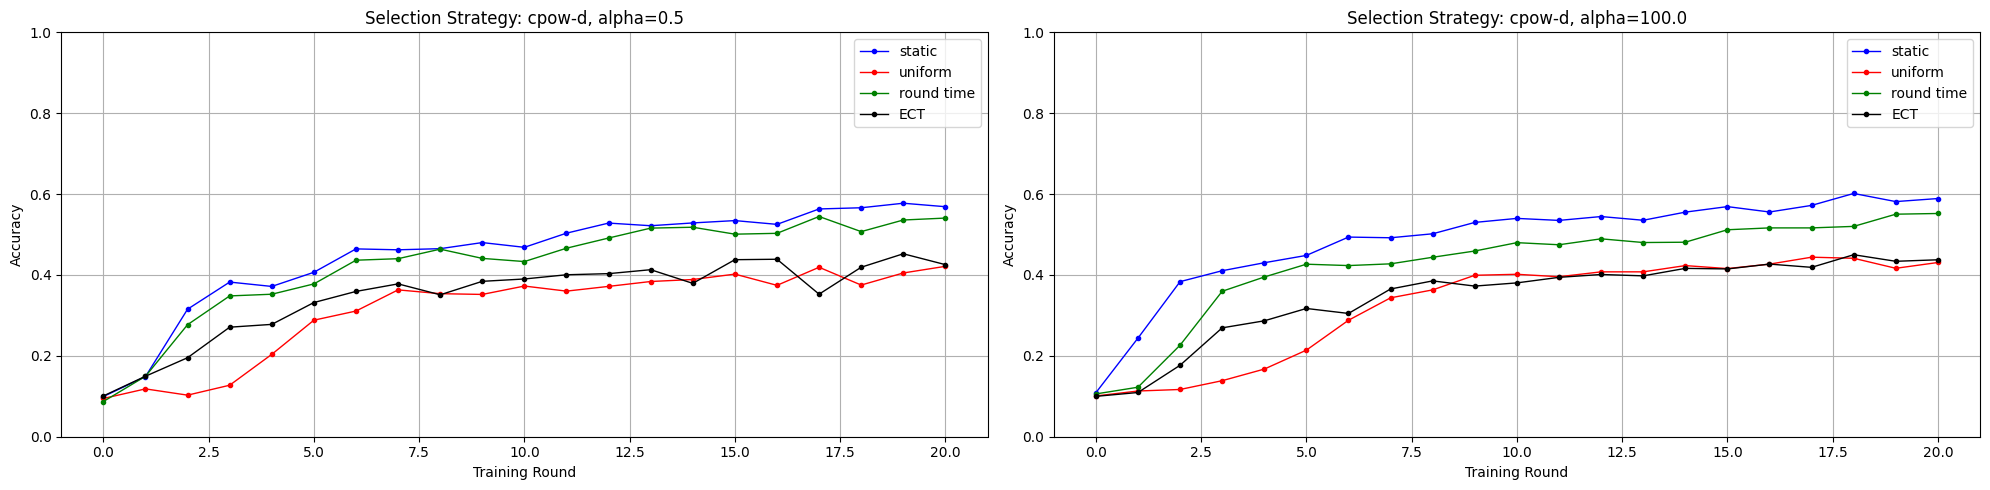

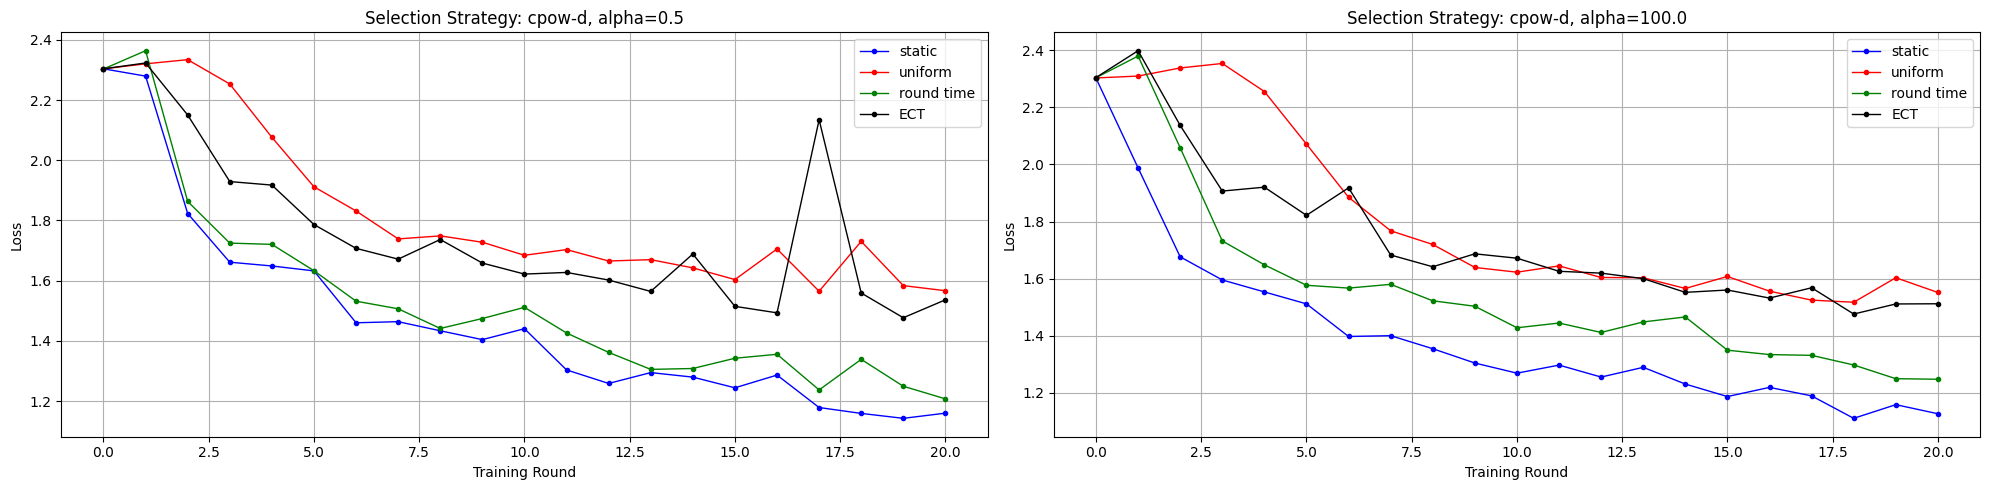

In [4]:
import matplotlib.pyplot as plt

strat_labels = {'rand': 'FedAvg', 'base': 'pow-d', 'cpow': 'cpow-d', 'rpow': 'rpow-d', 'dyn': 'Dyn.Sampling'}
conf_labels = {'so': 'static', 'uo': 'uniform', 'rt': 'round time', 'ecto': 'ECT'}
colors = {'so': 'b', 'uo': 'r', 'rt': 'g', 'ecto': 'k'}

strats = list(set([exp.variant for exp in EXPERIMENTS]))

alpha = [0.5, 100.0]

# Plots accuracy and loss split by selection strategy, configuration policy, and value of alpha

for i, strat in enumerate(strats):
    fig, ax = plt.subplots(1, 2, figsize=(20,5))            
    for k, a in enumerate(alpha):
    
        # Calculates avg. accuracy over N replications of the same <selection, configuration, alpha> tuple
        exp_with_strat = [exp for exp in EXPERIMENTS if exp.variant==strat and exp.alpha==a]
        for opt in conf_labels:
            exp_with_strat_and_opt = [exp for exp in exp_with_strat if exp.opt==opt]
            if len(exp_with_strat_and_opt) < 1:
                continue
            avg_accuracy = []
            for j in range(max([exp.rounds for exp in exp_with_strat_and_opt])):
                avg_accuracy.append(sum([results[exp][0][j] for exp in exp_with_strat_and_opt])/len(exp_with_strat_and_opt))

            ax[k].plot(range(max([exp.rounds for exp in exp_with_strat_and_opt])), avg_accuracy, marker='o', linewidth=1, markersize=3, color=colors[opt], label=conf_labels[opt])

        ax[k].set_title('Selection Strategy: {}, alpha={}'.format(strat_labels[strat], a))
        ax[k].set_xlabel('Training Round')
        ax[k].set_ylabel('Accuracy')
        ax[k].set_ylim([0, 1])
        ax[k].grid(True)
        ax[k].legend()
        
    # fig.suptitle('Accuracy by <selection strategy, configuration strategy, alpha={}>'.format(a), fontsize=18)
    fig.tight_layout()
    fig.savefig('plots/plot_accuracy_{}_{}.png'.format(strat, a), format='png')
    fig.show()
        
    fig, ax = plt.subplots(1, 2, figsize=(20,5))            
    for k, a in enumerate(alpha):
        # Calculates avg. loss over N replications of the same <selection, configuration, alpha> tuple
        exp_with_strat = [exp for exp in EXPERIMENTS if exp.variant==strat and exp.alpha==a]
        for opt in conf_labels:
            exp_with_strat_and_opt = [exp for exp in exp_with_strat if exp.opt==opt]
            if len(exp_with_strat_and_opt) < 1:
                continue
            avg_loss = []
            for j in range(max([exp.rounds for exp in exp_with_strat_and_opt])):
                avg_loss.append(sum([results[exp][1][j] for exp in exp_with_strat_and_opt])/len(exp_with_strat_and_opt))

            ax[k].plot(range(max([exp.rounds for exp in exp_with_strat_and_opt])), avg_loss, marker='o', linewidth=1, markersize=3, color=colors[opt], label=conf_labels[opt])

        ax[k].set_title('Selection Strategy: {}, alpha={}'.format(strat_labels[strat], a))
        ax[k].set_xlabel('Training Round')
        ax[k].set_ylabel('Loss')
        ax[k].grid(True)
        ax[k].legend()
    
    # fig.suptitle('Loss by <selection strategy, configuration strategy, alpha={}>'.format(a), fontsize=18)
    fig.tight_layout()
    fig.savefig('plots/plot_loss_{}_{}.png'.format(strat, a), format='png')
    # fig.show()



In [5]:
for a in alpha:

    print('\n ACCURACY ({:.2f}):'.format(a))
    for i, strat in enumerate(strats):

        # Calculates avg. accuracy over N replications of the same <selection, configuration, alpha> tuple
        exp_with_strat = [exp for exp in EXPERIMENTS if exp.variant==strat and exp.alpha==a]
        for opt in conf_labels:
            exp_with_strat_and_opt = [exp for exp in exp_with_strat if exp.opt==opt]
            if len(exp_with_strat_and_opt) < 1:
                continue
            avg_accuracy = []
            for j in range(max([exp.rounds for exp in exp_with_strat_and_opt])):
                avg_accuracy.append(sum([results[exp][0][j] for exp in exp_with_strat_and_opt])/len(exp_with_strat_and_opt))
            print('{}, {}: {:.2f}'.format(strat, opt, avg_accuracy[-1]))


    print('\n LOSS ({:.2f}):'.format(a))
    for i, strat in enumerate(strats):

        # Calculates avg. loss over N replications of the same <selection, configuration, alpha> tuple
        exp_with_strat = [exp for exp in EXPERIMENTS if exp.variant==strat and exp.alpha==a]
        for opt in conf_labels:
            exp_with_strat_and_opt = [exp for exp in exp_with_strat if exp.opt==opt]
            if len(exp_with_strat_and_opt) < 1:
                continue
            avg_loss = []
            for j in range(max([exp.rounds for exp in exp_with_strat_and_opt])):
                avg_loss.append(sum([results[exp][1][j] for exp in exp_with_strat_and_opt])/len(exp_with_strat_and_opt))
            print('{}, {}: {:.2f}'.format(strat, opt, avg_loss[-1]))



 ACCURACY (0.50):
rpow, so: 0.59
rpow, uo: 0.47
rpow, rt: 0.52
rpow, ecto: 0.54
dyn, so: 0.47
dyn, uo: 0.29
dyn, rt: 0.37
dyn, ecto: 0.31
rand, so: 0.56
rand, uo: 0.44
rand, rt: 0.48
rand, ecto: 0.53
base, so: 0.61
base, uo: 0.50
base, rt: 0.55
base, ecto: 0.51
cpow, so: 0.57
cpow, uo: 0.42
cpow, rt: 0.54
cpow, ecto: 0.43

 LOSS (0.50):
rpow, so: 1.13
rpow, uo: 1.45
rpow, rt: 1.42
rpow, ecto: 1.26
dyn, so: 4.84
dyn, uo: 1.92
dyn, rt: 1.85
dyn, ecto: 2.12
rand, so: 1.21
rand, uo: 1.56
rand, rt: 1.69
rand, ecto: 1.31
base, so: 1.06
base, uo: 1.36
base, rt: 1.25
base, ecto: 1.34
cpow, so: 1.16
cpow, uo: 1.57
cpow, rt: 1.21
cpow, ecto: 1.54

 ACCURACY (100.00):
rpow, so: 0.61
rpow, uo: 0.49
rpow, rt: 0.52
rpow, ecto: 0.54
dyn, so: 0.71
dyn, uo: 0.33
dyn, rt: 0.40
dyn, ecto: 0.42
rand, so: 0.62
rand, uo: 0.48
rand, rt: 0.55
rand, ecto: 0.57
base, so: 0.57
base, uo: 0.48
base, rt: 0.54
base, ecto: 0.54
cpow, so: 0.59
cpow, uo: 0.43
cpow, rt: 0.55
cpow, ecto: 0.44

 LOSS (100.00):
rpow, so: 

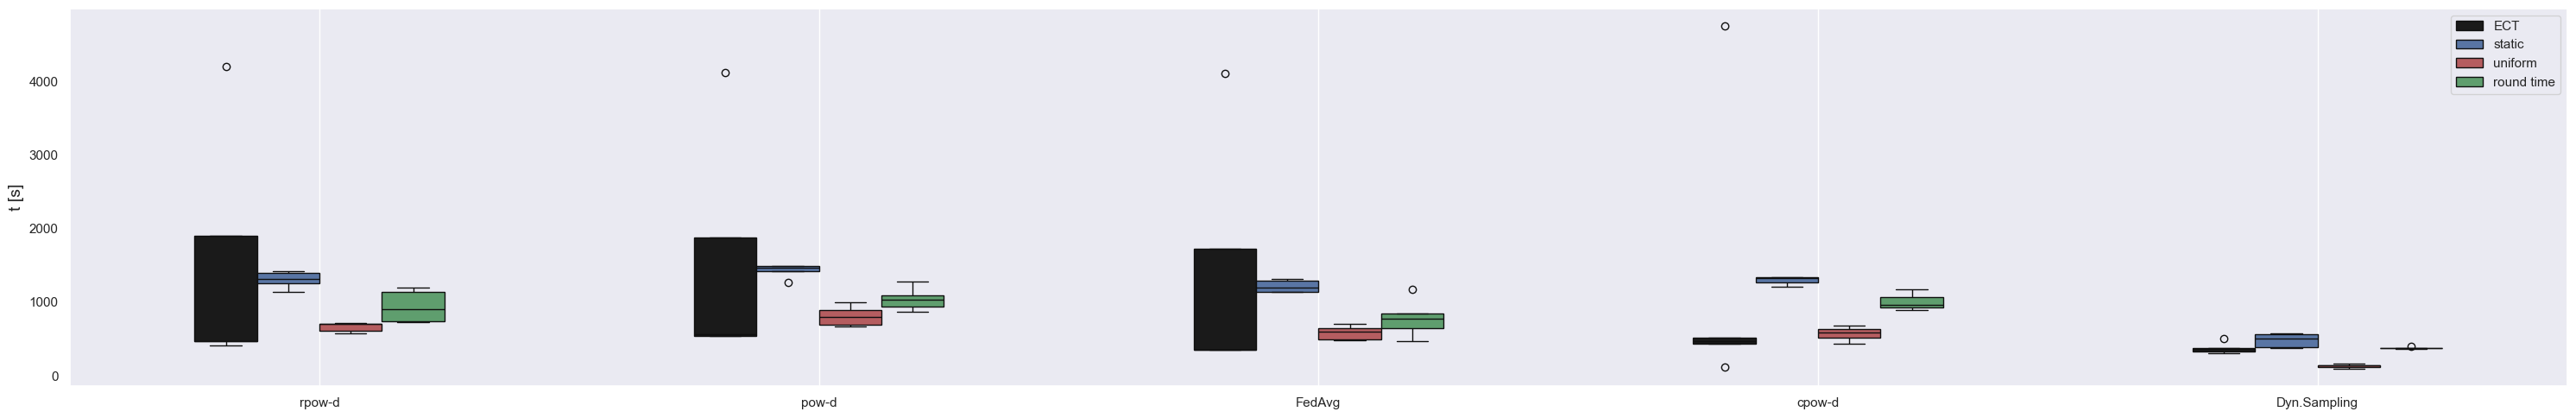

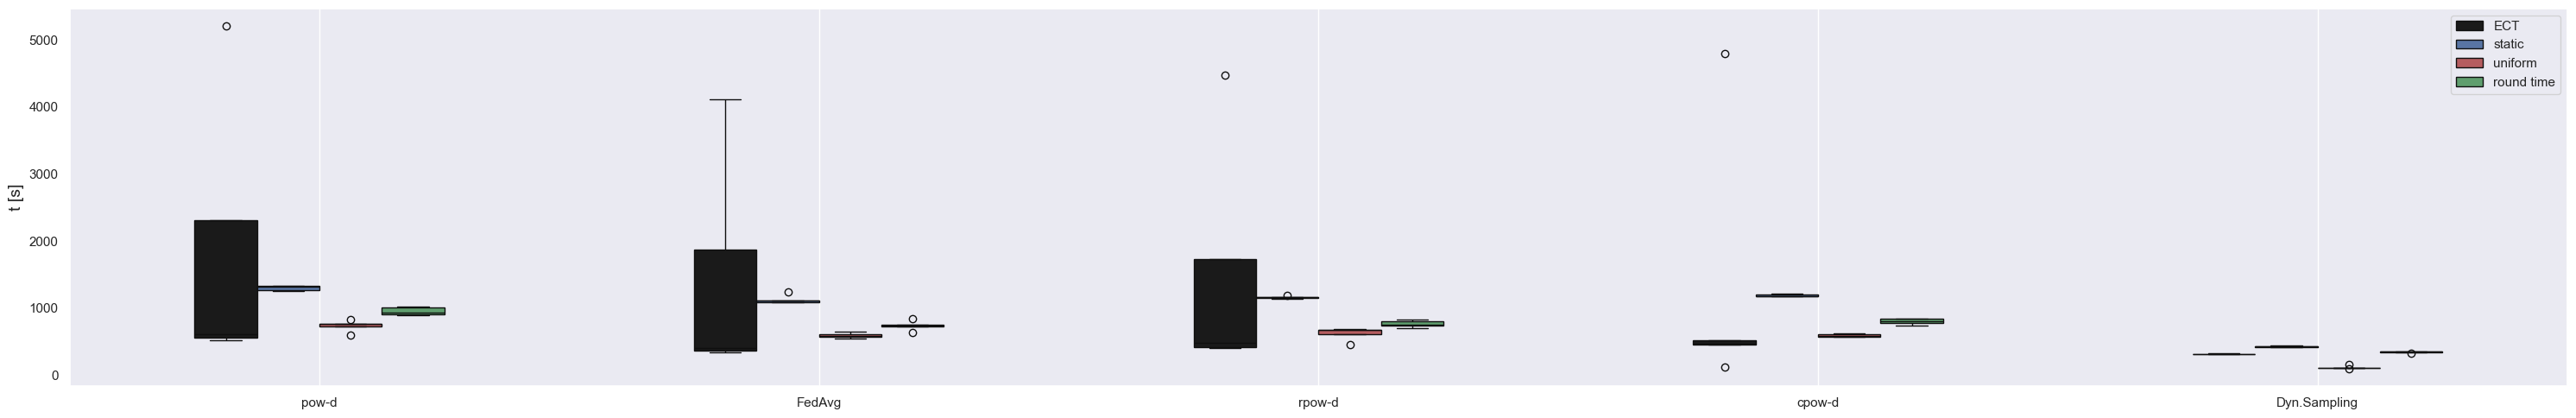

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

strat_labels = {'rand': 'FedAvg', 'base': 'pow-d', 'cpow': 'cpow-d', 'rpow': 'rpow-d', 'dyn': 'Dyn.Sampling'}
conf_labels = {'so': 'static', 'uo': 'uniform', 'rt': 'round time', 'ecto': 'ECT'}
colors = {'static': 'b', 'uniform': 'r', 'round time': 'g', 'ECT': 'k'}
alpha = [0.5, 100.0]

# Plots wall-clock time distributions for each <selection, configuration, alpha> tuple 

for a in alpha:
    x = [strat_labels[exp.variant] for exp in EXPERIMENTS if exp.alpha==a]
    y = [exp.duration for exp in EXPERIMENTS if exp.alpha==a]
    hue = [conf_labels[exp.opt] for exp in EXPERIMENTS if exp.alpha==a]
    
    sns.set_theme(rc={'figure.figsize':(30, 5)})
    sns.boxplot(x=x, y=y, hue=hue, palette=colors, width=0.5)
    # plt.title('Wall-clock time for alpha={}'.format(a), fontsize=14)
    plt.ylabel('t [s]', fontsize=14)
    plt.grid()  
    plt.tight_layout()
    plt.savefig('plots/plot_time_{}.png'.format(a), format='png')
    plt.show()

In [7]:
for a in alpha:
    print('\nALPHA: {}'.format(a))
    times = dict()
    for exp in EXPERIMENTS:
        if exp.alpha!=a:
            continue
        if (exp.variant, exp.opt) in times:
            times[(exp.variant, exp.opt)][1] = (times[(exp.variant, exp.opt)][1]*times[(exp.variant, exp.opt)][0] + exp.duration/60)/(times[(exp.variant, exp.opt)][0]+1)
            times[(exp.variant, exp.opt)][0] = times[(exp.variant, exp.opt)][0] + 1
        else:
            times[(exp.variant, exp.opt)] = [1, exp.duration/60]
    
    for strat in strats:
        for opt in conf_labels:
            print('{}, {}: {:.1f}'.format(strat, opt, times[(strat, opt)][1]))


ALPHA: 0.5
rpow, so: 21.8
rpow, uo: 11.1
rpow, rt: 15.7
rpow, ecto: 24.9
dyn, so: 8.0
dyn, uo: 2.2
dyn, rt: 6.3
dyn, ecto: 6.3
rand, so: 20.3
rand, uo: 9.7
rand, rt: 13.1
rand, ecto: 23.0
base, so: 23.7
base, uo: 13.5
base, rt: 17.4
base, ecto: 25.5
cpow, so: 21.6
cpow, uo: 9.5
cpow, rt: 16.9
cpow, ecto: 21.0

ALPHA: 100.0
rpow, so: 19.3
rpow, uo: 10.4
rpow, rt: 12.7
rpow, ecto: 25.1
dyn, so: 7.1
dyn, uo: 1.9
dyn, rt: 5.8
dyn, ecto: 5.3
rand, so: 18.8
rand, uo: 9.9
rand, rt: 12.3
rand, ecto: 23.7
base, so: 21.7
base, uo: 12.3
base, rt: 15.9
base, ecto: 30.7
cpow, so: 19.8
cpow, uo: 9.9
cpow, rt: 13.4
cpow, ecto: 21.2
